In [ ]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

def find_repo_root(marker="tools/python/udbase.py"):
    here = Path.cwd().resolve()
    for parent in [here] + list(here.parents):
        if (parent / marker).exists():
            return parent
    raise FileNotFoundError("Could not locate u-dales repo root. Update marker if needed.")

repo_root = find_repo_root()
python_tools = repo_root / "tools/python"
if str(python_tools) not in sys.path:
    sys.path.insert(0, str(python_tools))

from udbase import UDBase
HAS_UDBASE = True

expnr = 101
expdir = repo_root / "examples" / f"{expnr:03d}"
if not expdir.exists():
    print("Example experiment directory not found locally; synthetic data will be used.")

## 1. time_average: mean and variance of time series

We load facet pressure as an example. If the experiment output is unavailable, synthetic data is generated so the workflow still runs.

Loaded geometry: 320 faces, 225 vertices
Falling back to synthetic data: File not found: C:\Users\mvr\OneDrive - Imperial College London\codes\uDALES\u-dales\examples\101\fac.101.nc


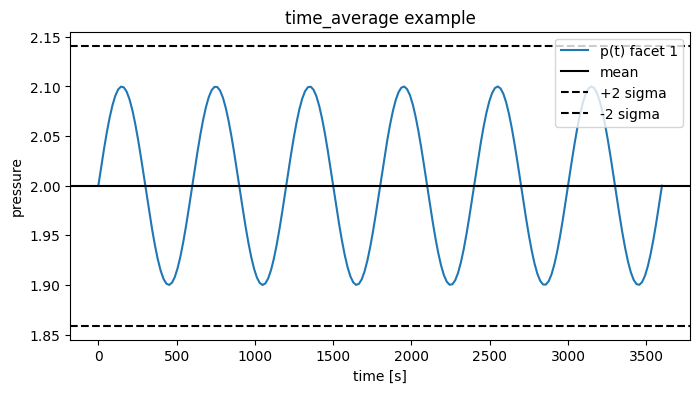

In [2]:
def load_facet_pressure(expnr=expnr, expdir=expdir):
    if HAS_UDBASE and expdir.exists():
        try:
            sim = UDBase(expnr=expnr, path=expdir)
            p_val = sim.load_fac_momentum("pres")
            t_val = sim.load_fac_momentum("t")
            return p_val, t_val
        except Exception as exc:
            print(f"Falling back to synthetic data: {exc}")
    t_val = np.linspace(0.0, 3600.0, 200)
    base = 2.0 + 0.1 * np.sin(2 * np.pi * t_val / 600.0)
    p_val = np.vstack([base, base + 0.05 * np.cos(2 * np.pi * t_val / 300.0)])
    return p_val, t_val

p, t = load_facet_pressure()
p_mean = UDBase.time_average(p, t) if HAS_UDBASE else np.mean(p, axis=-1)
p_var = np.mean((p - p_mean[..., None]) ** 2, axis=-1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, p[0], label="p(t) facet 1")
ax.axhline(p_mean[0], color="k", label="mean")
sigma = np.sqrt(p_var[0])
ax.axhline(p_mean[0] + 2 * sigma, color="k", linestyle="--", label="+2 sigma")
ax.axhline(p_mean[0] - 2 * sigma, color="k", linestyle="--", label="-2 sigma")
ax.set_xlabel("time [s]")
ax.set_ylabel("pressure")
ax.legend()
ax.set_title("time_average example")
plt.show()

### Two-variable covariance

We estimate the covariance between facet pressure and shear stress. Synthetic data is used when real outputs are missing.

In [3]:
def load_pressure_and_tau():
    p_val, t_val = load_facet_pressure()
    rng = np.random.default_rng(0)
    taux = 0.05 * np.sin(2 * np.pi * t_val / 450.0)
    taux = np.vstack([taux, taux + 0.01 * rng.standard_normal(t_val.shape)])
    return p_val, t_val, taux

p, t, taux = load_pressure_and_tau()
p_mean = UDBase.time_average(p, t) if HAS_UDBASE else np.mean(p, axis=-1)
taux_mean = UDBase.time_average(taux, t) if HAS_UDBASE else np.mean(taux, axis=-1)
cov_ptaux = np.mean((p - p_mean[..., None]) * (taux - taux_mean[..., None]), axis=-1)
print(f"First facet: pbar={p_mean[0]:.3f}, tauxbar={taux_mean[0]:.3f}, cov={cov_ptaux[0]:.3f}")

Loaded geometry: 320 faces, 225 vertices
Falling back to synthetic data: File not found: C:\Users\mvr\OneDrive - Imperial College London\codes\uDALES\u-dales\examples\101\fac.101.nc
First facet: pbar=2.000, tauxbar=-0.000, cov=0.000


## 2. merge_stat: combine short-term averages

Identical to the MATLAB utility: merges non-overlapping time windows, discarding the oldest samples that do not complete a window.

In [ ]:
# Use library implementation (matches MATLAB version)
merge_stat = UDBase.merge_stat

# Synthetic example matching the MATLAB tutorial dimensions
np.random.seed(0)
uxyt = 1.0 + 0.1 * np.random.randn(256, 3)
wxyt = 0.05 * np.random.randn(256, 3)
upupxyt = 0.2 + 0.01 * np.abs(np.random.randn(256, 3))
upwpxyt = 0.01 * np.random.randn(256, 3)
Nwindow = 2
ux_long, wx_long, upw_long = merge_stat(uxyt, Nwindow, Y=wxyt, XpYp=upwpxyt)
ux_long_var = merge_stat(uxyt, Nwindow, XpXp=upupxyt)[1]
print(f"Short-term shape {uxyt.shape} -> long-term mean shape {ux_long.shape}")
print(f"First level: ubar={ux_long[0,0]:.3f}, wbar={wx_long[0,0]:.3f}, cov={upw_long[0,0]:.3f}")
print(f"First level variance estimate={ux_long_var[0,0]:.3f}")

Short-term shape (256, 3) -> long-term mean shape (256, 1)
First level: ubar=1.069, wbar=-0.018, cov=-0.002
First level variance estimate=0.211


## 3. coarsegrain_field: FFT-based planar filter

Identical to the MATLAB coarse-graining example: periodic planar filters applied to 3D fields with multiple filter lengths.

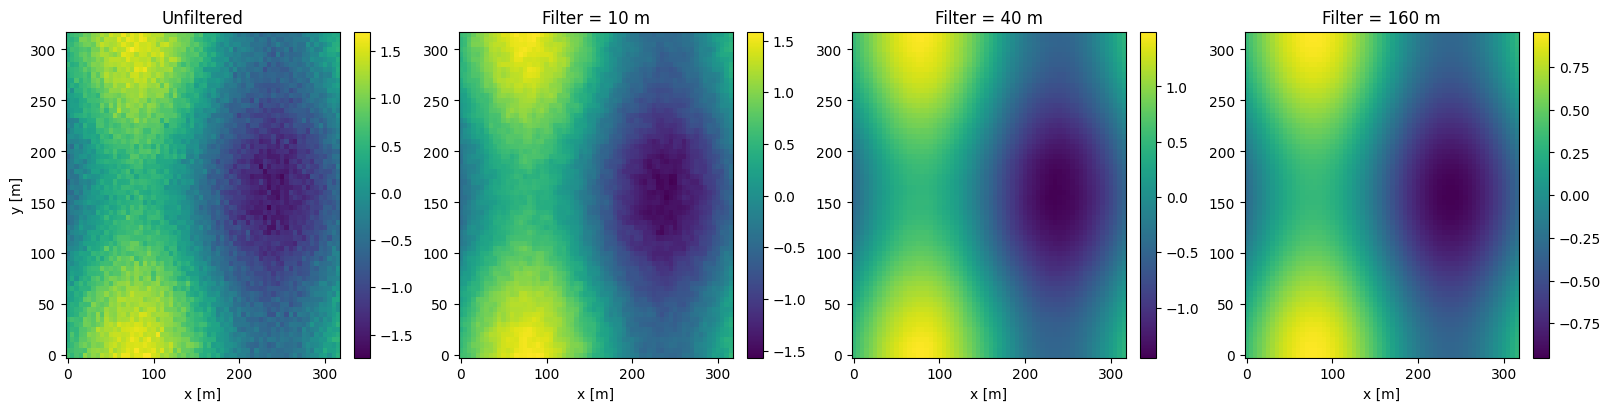

In [ ]:
coarsegrain = UDBase.coarsegrain_field

# Synthetic field and demo
nx = ny = 64
nz = 12
dx = dy = 5.0
xm = np.arange(nx) * dx
ym = np.arange(ny) * dy
xg, yg = np.meshgrid(xm, ym, indexing="ij")
base_field = np.sin(2 * np.pi * xg / (nx * dx)) + 0.5 * np.cos(2 * np.pi * yg / (ny * dy))
field = base_field[:, :, None] + 0.1 * np.random.randn(nx, ny, nz)
filter_lengths = [10.0, 40.0, 160.0]
filtered = coarsegrain(field, filter_lengths, xm, ym)

k_level = 5
fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
pcm = axes[0].pcolormesh(xm, ym, field[:, :, k_level].T, shading="auto")
axes[0].set_title("Unfiltered")
axes[0].set_xlabel("x [m]")
axes[0].set_ylabel("y [m]")
fig.colorbar(pcm, ax=axes[0])

for ax, L, idx in zip(axes[1:], filter_lengths, range(len(filter_lengths))):
    pcm = ax.pcolormesh(xm, ym, filtered[:, :, k_level, idx].T, shading="auto")
    ax.set_title(f"Filter = {L:.0f} m")
    ax.set_xlabel("x [m]")
    fig.colorbar(pcm, ax=ax)

plt.show()